In [1]:
from pyemma.msm import MaximumLikelihoodMSM, BayesianMSM, MaximumLikelihoodHMSM, its
from bhmm import lag_observations
import pyemma.plots as mplt
import pyemma.coordinates as coor
from msmbuilder.cluster import NDGrid
from sklearn.pipeline import Pipeline
import pickle
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import entropy
import pandas as pd

/Users/robert_arbon/Google Drive/Research/PyEMMA/pyemma/__init__.py:111: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.2, you have 2.4+906.gaef6a90c.dirty.
  .format(latest=latest, current=current), category=UserWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 

In [13]:
taus = [5, 8, 37, 94, 484]
results = [pd.read_hdf('h_state_selection.h5', key='tau{}'.format(x)) for x in taus]

In [16]:
df = pd.concat(results)

In [18]:
df.head()

,aic,bic,dofs,entropy,icl,k,n_obs,tau
0,1.456304e+06,1.460275e+06,396,180.331170,1.460636e+06,2,167211,5
1,1.373305e+06,1.379281e+06,596,1082.124388,1.381445e+06,3,167211,5
2,1.284115e+06,1.292107e+06,797,4281.663465,1.300670e+06,4,167211,5
3,1.259943e+06,1.269960e+06,999,11973.739080,1.293908e+06,5,167211,5
4,1.246784e+06,1.258837e+06,1202,17063.899872,1.292965e+06,6,167211,5


In [33]:
crit = df.loc[:, ['aic', 'bic', 'icl', 'k', 'tau']]

In [34]:
crit_melt = pd.melt(frame=crit, id_vars=['k', 'tau'], value_name='score', var_name='criterion')
crit_melt.loc[:, 'score'] *= (-0.5)



In [147]:
crit_melt.loc[:, 'criterion'] = crit_melt.loc[:, 'criterion'].str.upper()

In [148]:
min_scores = crit_melt.groupby(['tau', 'criterion'])['score'].transform('max')
idx = crit_melt['score'] == min_scores
best = crit_melt.loc[idx, :]
best

,k,tau,criterion,score
7,9,5,AIC,-608071.498230
14,8,8,AIC,-629566.090849
23,9,37,AIC,-700180.987945
29,7,94,AIC,-745023.420463
39,9,484,AIC,-810071.370484
47,9,5,BIC,-617181.038420
54,8,8,BIC,-637642.848828
59,5,37,BIC,-706998.218796
66,4,94,BIC,-749446.048558
73,3,484,BIC,-814743.303268


In [149]:
criteria = crit_melt['criterion'].unique()


In [150]:
best_k = pd.read_hdf('best_k.h5')
best_k.loc[:, 'n_resolvable'] += 1 # Make a correction! 

In [151]:
best_k

,best_k,n_resolvable,tau
0,8,8,5
1,4,6,8
2,4,4,37
3,3,3,94
4,2,2,484


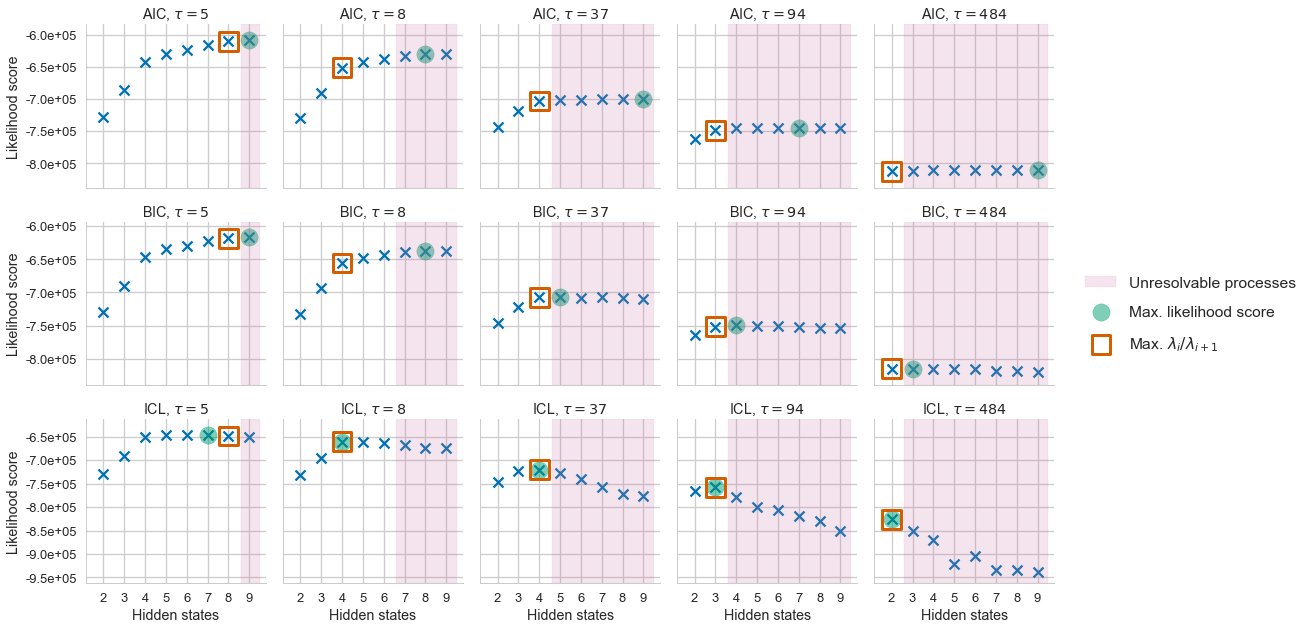

In [194]:
from matplotlib.markers import MarkerStyle
import matplotlib.transforms as mtransforms
import matplotlib.patches as patches
import matplotlib.ticker as ticker

with sns.plotting_context('talk', font_scale=1):
    sns.set_style('whitegrid')

    # parameters for axes
    cols = sns.color_palette('colorblind', 4)
    max_k = crit_melt['k'].max()
    delx = 0.1
    
    
    g = sns.FacetGrid(data=crit_melt, row='criterion',col='tau', row_order=criteria, col_order=taus, 
                      sharey='row')
    g = g.map(plt.scatter, 'k', 'score', s=100, marker='x', color=cols[0])
    
    for ax in g.axes.flatten():
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:4.1e}'))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))
    
    g = g.set_axis_labels('Hidden states', 'Likelihood score')
    g = g.set_titles(r'{row_name}, $\tau={col_name}$')
    
    for (row_i, col_j, hue_k), data_ijk in g.facet_data():
        ax = g.facet_axis(row_i, col_j)
        
        # Best likelihood criteria
        idx = (best['criterion']==criteria[row_i]) & (best['tau'] == taus[col_j])
        k = best.loc[idx, 'k']
        y = best.loc[idx, 'score']
        
        leg1 = ax.scatter(k, y, marker='o', s=300, alpha=0.5, linewidths=None, color=cols[1], 
                   label='Max. likelihood score')
        
        # largest eigenvalue gap
        jdx = (best_k['tau'] == taus[col_j])
        k = best_k.loc[jdx, 'best_k'].values[0]
        kdx = (crit_melt['tau']==taus[col_j]) & (crit_melt['k']==k) & (crit_melt['criterion']==criteria[row_i])
        y = crit_melt.loc[kdx, 'score']
        
        leg2 = ax.scatter(k, y, marker='s', s=350, facecolors='none', linewidths=3, color=cols[2], 
                  label='Max. $\lambda_i/\lambda_{i+1}$')
    
        # Shade out unresolvable 
        
        trans = mtransforms.blended_transform_factory(
            ax.transData, ax.transAxes)
        unresolve = best_k.loc[jdx, 'n_resolvable'].values[0] + 0.5 + delx
        width = -unresolve+(max_k+0.5)
        rect = patches.Rectangle((unresolve,0), width=width, height=1,
                                 transform=trans, color=cols[3],
                                 alpha=0.2, label='Unresolvable processes')
        leg3 = ax.add_patch(rect)
    
    g.axes.flatten()[-1].legend(bbox_to_anchor=(1, 0.5), 
                                bbox_transform=plt.gcf().transFigure, loc='center left', 
                               labelspacing=1, fontsize='medium')
#     g = g.fig.subplots_adjust(wspace=.2, hspace=.2)
    plt.savefig('Figures/h_state_selection_quad_well.pdf', dpi=300, bbox_inches='tight')